<h3 align="left">Workflow</h3>

Here I briefly discuss the workflow of this notebook.

1) We read in the data and create the temperature profiles.<br><br>

2) We use PCA to reduce the number of features from the 37 original features to only 2 features. This is done because we are trying to detect the most common profile in the dataset from a 2D plot. Something to keep in mind: the 2 principal components together explain 'only' approx. 91.4% of the variance of the original data (temperature-profiles). This means that some characteristics of the original data might not be displayed in the 2D plot.<br><br>

3) After detecting the most common profile from the 2D plot, we use pca.inverse_transform() to transform the data back to its original space. <br><br>

4) We plot the most common temperature profile in its original form.

Note that steps 3 and 4 are done simultaneously inside the *plot_profile()* function.

<br>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
from sklearn.preprocessing import StandardScaler

<br>

<h3 align="left">Read in the data</h3>

In [3]:
def read_netCDF4_data(filename):
    with Dataset(filename) as rootgrp:
        latitude = rootgrp['latitude'][:]
        longitude = rootgrp['longitude'][:]
        level = rootgrp['level'][:]
        time = rootgrp['time'][:]
        specific_humidity = rootgrp['q'][:][:][:][:]
        temperature = rootgrp['t'][:][:][:][:]
    return latitude, longitude, level, time, specific_humidity, temperature

In [4]:
latitude, longitude, level, time, specific_humidity, temperature = read_netCDF4_data("/home/jaminkiukkonen/Downloads/test_data.nc")

<br>

<h3 align="left">Create temperature profiles</h3>

In [5]:
def create_temperature_profiles(t):
    """
    This function creates temperature profiles such that
    each column represent one pressure level.
    For example, the first column has the temperatures associated
    with pressure level 1.
    
    parameters:
        t: a 4D tensor containing time, pressure level, latitude, longitude.
        
    returns:
        2D matrix where each column represents one pressure level.
    """
    i = 0
    T_profiles = np.zeros((t[:, 0, :, :].size, t[0, :, 0, 0].size), float)
    for day in range(0, len(time)):
        print(day)
        for lat in range(0, len(latitude)):
            for lon in range(0, len(longitude)):
                T_profiles[i, :] = t[day, :, lat, lon][None, :]
                i += 1
    return T_profiles

In [6]:
temperature_profiles = create_temperature_profiles(temperature)

0
1
2
3
4
5
6


In [7]:
temperature_profiles.shape

(7267680, 37)

<br>

<h3 align="left">PCA</h3>

In [8]:
# Scale the data for numerical stability
scaler = StandardScaler()
scaled_temperature_profiles = scaler.fit_transform(temperature_profiles)

In [9]:
scaled_temperature_profiles.shape

(7267680, 37)

- [Problem with scaling in PCA](https://stats.stackexchange.com/questions/105592/not-normalizing-data-before-pca-gives-better-explained-variance-ratio)

In [10]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_temperature_profiles)

In [11]:
pca_results.shape

(7267680, 2)

<br>

<h3 align="left">Detect the most common profile from a 2D histplot</h3>

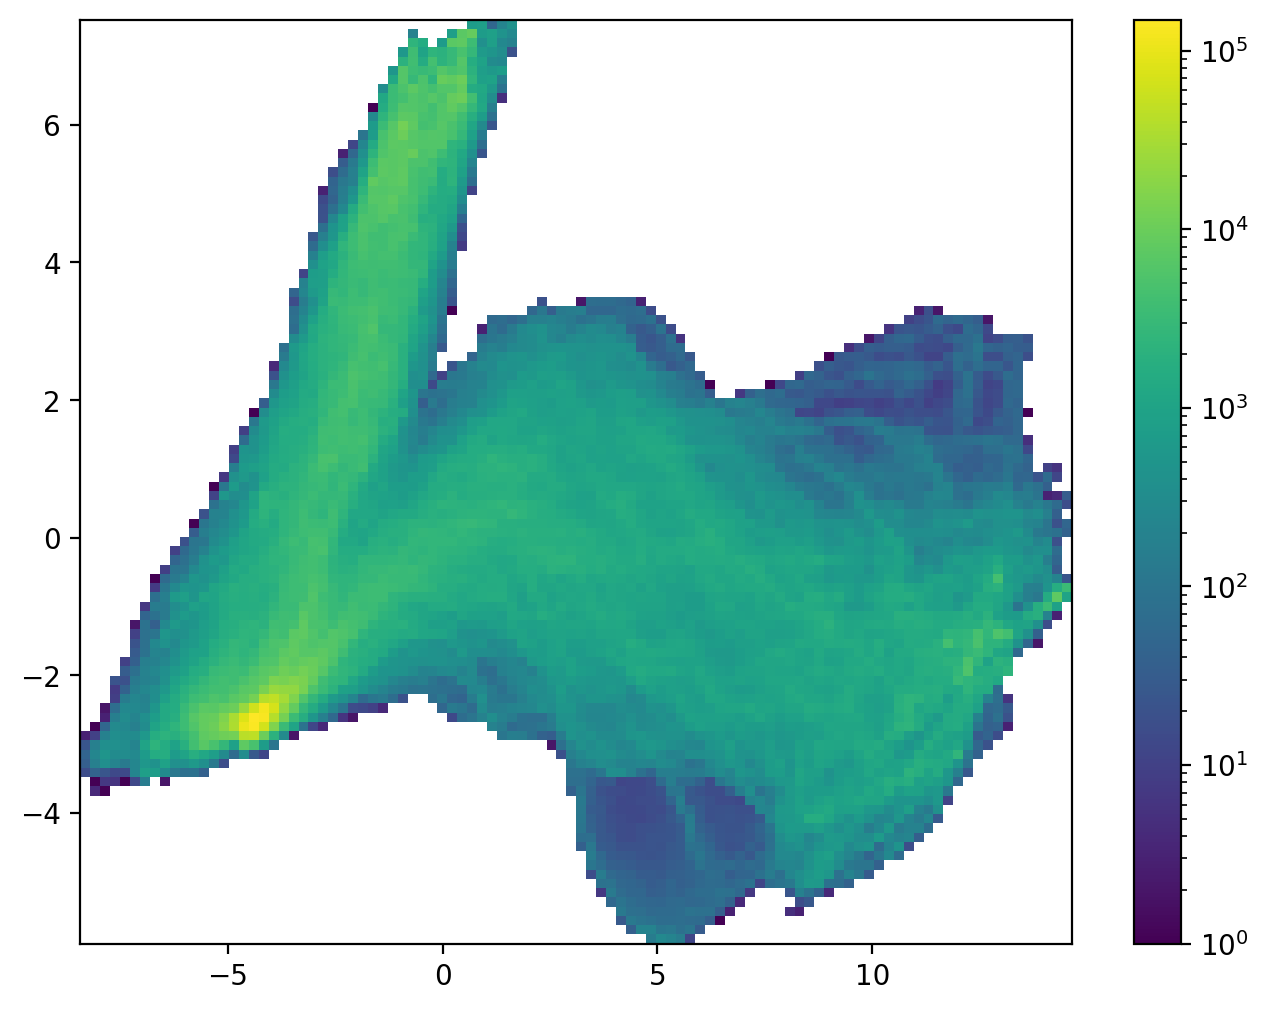

In [12]:
plt.figure(figsize=(8,6), dpi=200)
plt.hist2d(pca_results[:, 0], pca_results[:, 1], bins=100, norm=LogNorm())
plt.colorbar();
#plt.savefig('2dhist-PCA', dpi=200);

- The most common profile seems to be located somewhere around the point (-4.8, -3).

<br>

<h3 align="left">Inverse Transform</h3>

In [15]:
def plot_profile(pc1_interval, pc2_interval):
    """
    This function plots a random temperature profile from
    given intervals of principal components 1 & 2.
    
    pc1_interval: lower and upper boundary for principal component 1.
                  A random coordinate is taken from this interval.
    pc2_interval: lower and upper boundary for principal component 2.
                  A random coordinate is taken from this interval.
                  
    notes:
        - To plot a specific profile, give a really narrow intervals.
        - Both intervals must be given in the form: (lower_boundary, upper_boundary).
    """
    pc1_lower, pc1_upper = pc1_interval
    pc2_lower, pc2_upper = pc2_interval
    
    # All of the coordinates included in pc1_interval
    coords_pc1 = pca_results[(pca_results[:, 0] >= pc1_lower) & (pca_results[:, 0] <= pc1_upper)][:, 0]
    
    # All of the coordinates included in pc2_interval
    coords_pc2 = pca_results[(pca_results[:, 1] >= pc2_lower) & (pca_results[:, 1] <= pc2_upper)][:, 1]
    
    # Randomly select a coordinate from each interval to form a point (c1, c2)
    if coords_pc1.size and coords_pc2.size:    # Check that both arrays are non-empty
        c1 = np.random.choice(coords_pc1)
        c2 = np.random.choice(coords_pc2)
        point = np.array([c1, c2]).reshape(1, 2)
        
    # Perform inverse transformation
    inverse_point = pca.inverse_transform(point)
    
    # Transform the temperatures back to original Kelvins 
    # (they are scaled for the PCA using Standardscaler)
    original_temperatures = scaler.inverse_transform(inverse_point)
    
    # Plot the pressure levels agains the original temperatures
    plt.figure(figsize=(8,6), dpi=100)
    plt.plot(original_temperatures.ravel(), level)
    plt.gca().invert_yaxis()
    plt.xlabel('Temperature (K)', size=12, labelpad=11)
    plt.ylabel('Pressure level', size=12, labelpad=11)
    
    #return original_temperatures

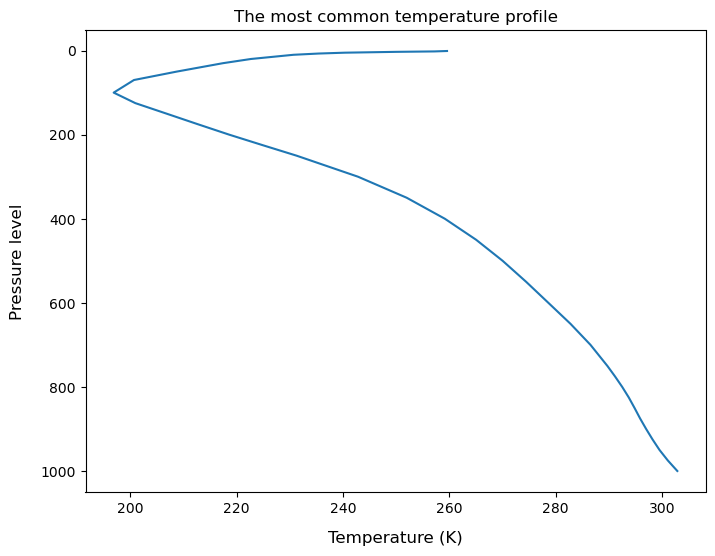

In [16]:
plot_profile((-4.9, -4.8), (-3, -2.9))
plt.title('The most common temperature profile', size=12);

<br>

Let's plot some other random temperature profiles as well to see how they differ from the most common one.

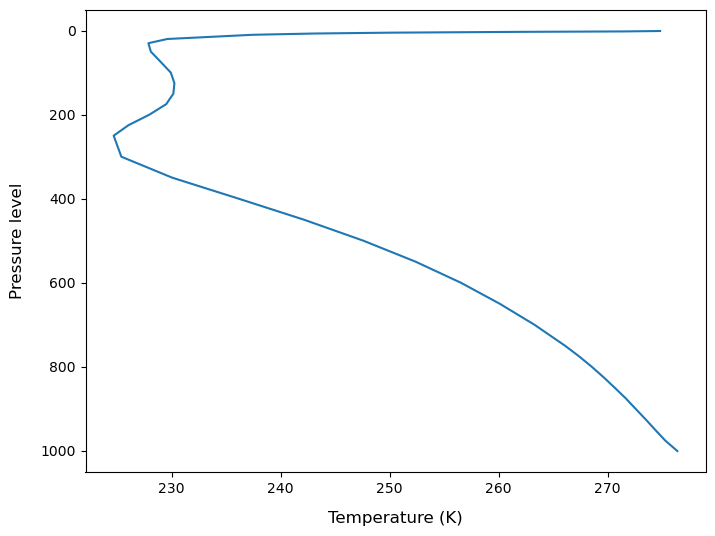

In [17]:
plot_profile((-1, 1), (5, 6))

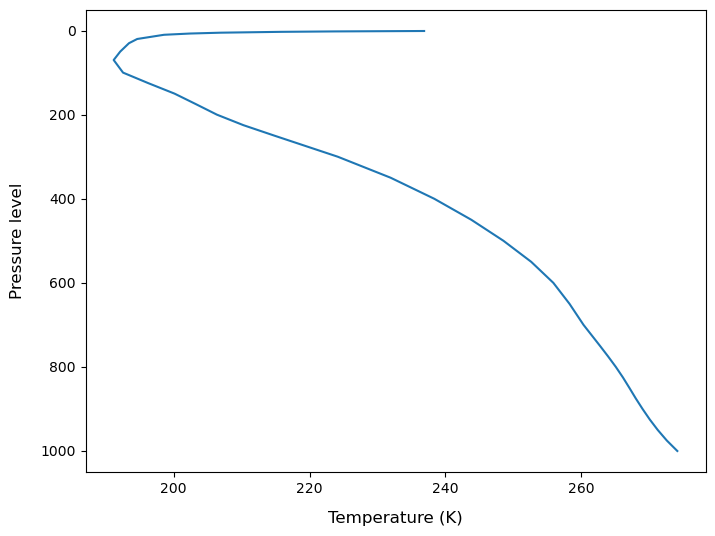

In [18]:
plot_profile((5, 5.1), (-4.1, -4))

<br>